## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 2 - Identification and removal of non-meteorological echoes

#### Overview
This notebook introduces a methods for identifying (and removing) radar echoes of non-meteorological origin.


We'll start as usual by importing the python modules we need for this notebook

In [2]:
import pyart
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file known to contain a variety of non-meteorological echoes, as shown in the lecture and set up a ```RadarMapDisplay``` object for that file, allowing us to plot the coastline which will help give an idea of the source of some of the clutter.

In [5]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/raine/cfradial/calib_v1/sur/20200507/ncas-mobile-x-band-radar-1_sandwith_20200507-080259_SUR_v1.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

We'll now plot up a multipanel PPI plot of 4 of the variables in the file (see practical 3 for more details on creating multi-panel plots). In addition to reflectivity (dBuZ) we'll also plot the co-polar cross correlation (RhoHV) which we'e seen to be a potentially useful discriminant between meteorological and other echoes, differential reflectivity (ZDR) and the signal quality index (SQI). 

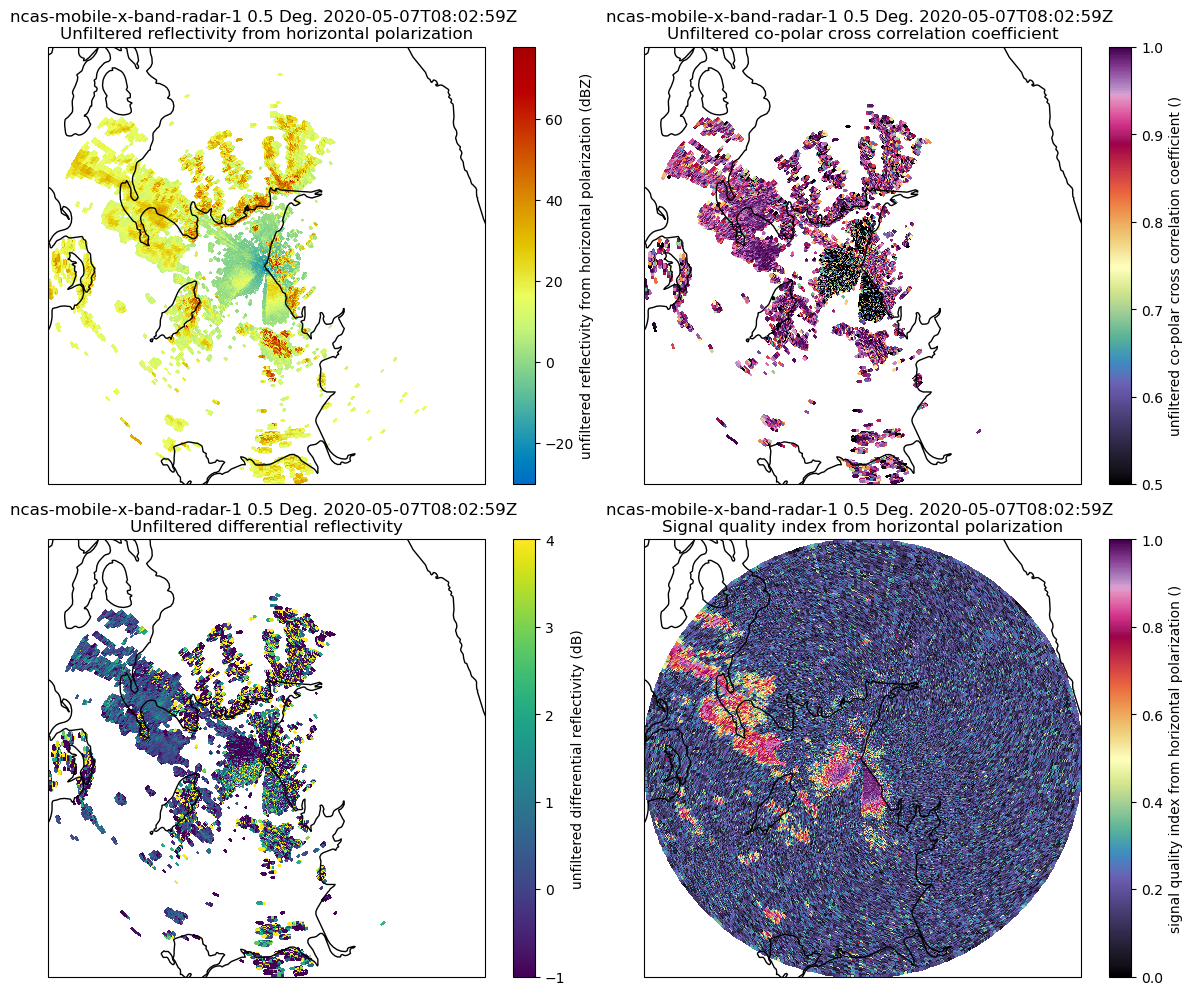

In [6]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=0, vmax=1,
                     embellish=False,
                     ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

In [7]:
gatefilter1 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter1.exclude_below('SQI',0.4) # Modify the object to now exclude all SQI data below a threshold
gatefilter1.exclude_below('RhoHV',0.9) # Modify the object to now exclude all RhoHV data below a threshold

The sector to the west of the radar contains a significant region of second trip echoes close to the radar. These are noticable in this case due to a number of factors:

1. The sharp edges to the echoes close in to the radar are a good visual clue.
2. The presence of moderate reflectivity echoes right at the edge of the domain in the same direction.
3. The radial striping within the echoes (particularly noticeable in ZDR).
4. Low SQI within the sector to the west, the second trip echoes are not visible amongst the background signal.

Of these the simplest avenue to persue from a coding perspective is the use of SQI as an indicator. From the PPI plot there's an indication that SQI above approximately 0.4 could be considered to represent first trip echoes. We can introduce the ```pyart.filters.GateFilter``` object here as a convenient method of applying filtering without modifying the underlying data within the radar file/object.

#### PyART GateFilters

PyART GateFilters provide a class for generating boolean (True/False) masks for use within other PyART functions (mainly plotting, but also some processing). As a boolean they are not correcting the data, simply acting as a tool to remove gates which aren't useful for the task in hand. While simple GateFilters can be built using one or more threhsolds on individual radar variables some inbuilt functions provide more complex methods for building the boolean masks, while it is also possible to do this externally to PyART and then parse them into a GateFilter to improve usability.

First we will define a basic GateFilter and then use it to replot the fields above.



We can then pass the ```gatefilter1``` object into the "gatefilter" argument within the ```plot_ppi``` function

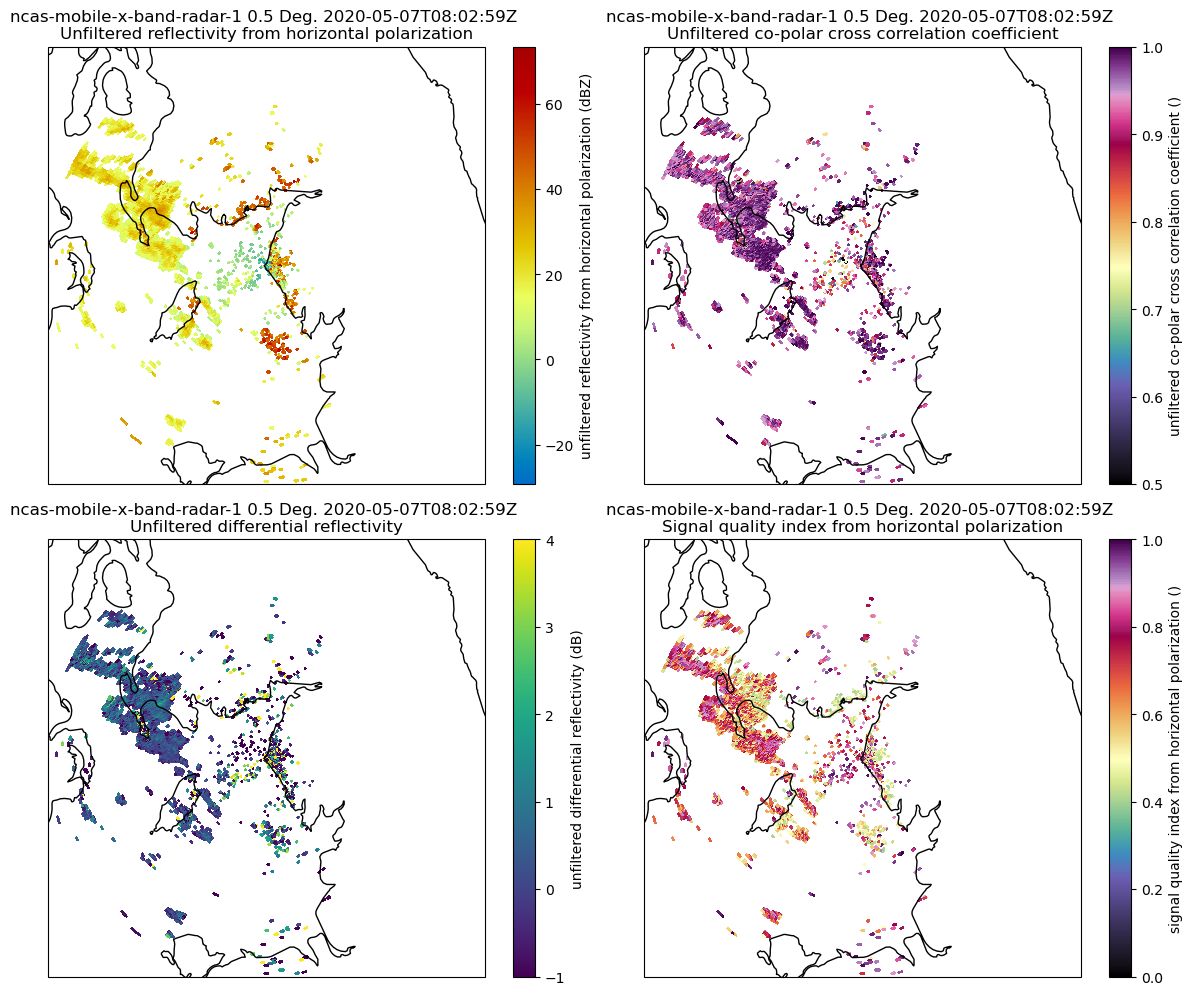

In [9]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter1,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                     gatefilter=gatefilter1,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     gatefilter=gatefilter1,
                     ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=0, vmax=1,
                     embellish=False,
                     gatefilter=gatefilter1,
                     ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

In [11]:
radar.azimuth['data'][0]

175.0122

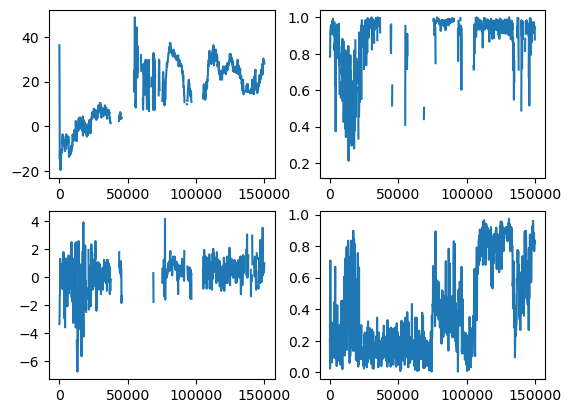

In [20]:
plt.subplot(221)

plt.plot(radar.range['data'],
         radar.fields['dBuZ']['data'][125])

plt.subplot(222)
plt.plot(radar.range['data'],
         radar.fields['RhoHV']['data'][125])

plt.subplot(223)
plt.plot(radar.range['data'],
         radar.fields['ZDR']['data'][125])

plt.subplot(224)
plt.plot(radar.range['data'],
         radar.fields['SQI']['data'][125])

Here we notice that while the bulk of the second trip returns to the west of the radar have been removed there is still a visible region of spurious echoes. Feel free to adjust the threshold value used from 0.4 to see how that impacts the PPIs.

As these echoes are now quite patchy in appearance we can use another approach, despeckling, to clean up the data. This is simply a method of removing individual gates, or small clusters of them, which are not connected to a larger echo. Once again, PyART now has an inbuilt function for applying this technique, ```pyart.correct.despeckle_field```. We can interogate this method in the notebook to see how it works:

In [ ]:
pyart.filters.moment_and_texture_based_gate_filter?

We will apply the speckle filter to the 'dBuZ' reflectivity field, keeping the default values for the threshold (all echoes above -100dBZ are included) and the size (at least 10 connected gates). We'll recreate our original gatefilter to mask the dBuZ field prior to identifying connected regions (if we simply pass the original, gatefilter1, it will be modified by the despeckle function).

In [ ]:
gatefilter2 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter2 = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)

In [ ]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter2,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     gatefilter=gatefilter2,
                 ax=ax2)

ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,
                     gatefilter=gatefilter2,
                     ax=ax3)

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("SQI", 0,
                 cmap=pycm.ChaseSpectral,
                     vmin=0, vmax=1,
                     gatefilter=gatefilter2,
                     ax=ax4)
plt.tight_layout()

In [ ]:
gatefilter3 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter3 = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)
gatefilter3.exclude_below('SQI',0.4)
gatefilter3 = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter3)

In [ ]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=-20,vmax=60, # Filtering can change the max values, so we'll fix the color for all plots
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter1,
                     vmin=-20,vmax=60,
                 ax=ax2)

ax2.coastlines(resolution='10m')

ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter2,
                     vmin=-20,vmax=60,
                 ax=ax3)
ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter3,
                     vmin=-20,vmax=60,
                 ax=ax4)
ax4.coastlines(resolution='10m')

plt.tight_layout()

In [ ]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/cope/cfradial/calib_v2/sur/20130718/ncas-mobile-xband-radar_davidstow-airfield_20130718-140305_SUR_v2.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

gatefilter3 = pyart.filters.GateFilter(radar) # Define a GateFilter object
gatefilter3 = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)
gatefilter3.exclude_below('SQI',0.4)
gatefilter3 = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter3)

In [ ]:
w = h = 80000

proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter3,
                     width=w,
                     height=h,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHV", 0,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                     embellish=False,
                     width=w,
                     height=h,
                 ax=ax2)
ax2.coastlines(resolution='10m')

ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("ZDR", 0, 
                     vmin=-1, vmax=4,
                     embellish=False,
                     width=w,
                     height=h,
                     ax=ax3)
ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                     embellish=False,
                     width=w,
                     height=h,
                     cmap=pycm.HomeyerRainbow,
                     vmin=-20, vmax=60,
                     ax=ax4)
ax4.coastlines(resolution='10m')

plt.tight_layout()

In [ ]:
import wradlib

In [ ]:
import nrt.quality_control.fuzzy_logic as nrt_fl

In [ ]:
nrt_fl.classify_radar_object?

In [ ]:
rho_texture = pyart.util.texture_along_ray(radar, 'RhoHV', wind_size=7)
radar.add_field('RhoText',{'data':rho_texture,'standard_name':'rho_texture'})

zdr_texture = pyart.util.texture_along_ray(radar, 'ZDR', wind_size=7)
radar.add_field('zdrText',{'data':zdr_texture,'standard_name':'zdr_texture'})

dbz_texture = pyart.util.texture_along_ray(radar, 'dBuZ', wind_size=7)
radar.add_field('dbzText',{'data':dbz_texture,'standard_name':'dbz_texture'})

In [ ]:
raddisp.plot_ppi_map('RhoText',
                 width=w,
                     height=h,
                    vmin=0,vmax=0.25)

In [ ]:
GC_dict = {'dBuZ':((-50,10,20,100,-5555),(0, 0, 1, 1,-5555)),
           'RhoText':((0.05,0.2,0.4,-5555),(0,1,0,-5555)),
           'zdrText':((0,1,3,10),(0,0.1,1,1)),
           'RhoHV':((0, 0.4, 0.7, 1), (0, 1, 1, 0))}

IN_dict = {'ZDR': ((0, 2, 4, 20), (0, 0, 1, 1)),
           'RhoHV': ((0.6, 0.8, 0.89, 1), (0, 0.5, 1, 0)),
           'zdrText': ((0, 1, 2), (0, 1, 0)),
           'RhoText':((0,0.05,0.1,-5555),(0,1,0,-5555)),
           'dBuZ': ((-11,-10,20,21),(0,1,1,0))}

RN_dict = {'ZDR': ((-2, 0, 0.1, 4, 10), (0, 0, 1, 1, 0)),
           'RhoText':((0,0.05,0.1,-5555),(1,0.1,0,-5555)),
           'RhoHV': ((0.9, 0.94, 0.98, 1,-5555), (0, 0.4, 1, 1,-5555)),
           'dBuZ': ((-50,-10,0,60,100),(0,0,1,1,0)),
           'SQI': ((0,0.5,0.6,1.0,-5555),(0,0,1,1,-5555))}

QC_dictionary = {'GC':GC_dict,
                 'IN':IN_dict,
                 'RN':RN_dict}

HLIST = ['GC', 'RN', 'IN']

In [ ]:
nrt_fl.classify_radar_object(
    radar,
    QC_dictionary,
    list_of_classification_indexes=HLIST,
    threshold=0,
    fractional=True,
    debug=True,
    new_field_name='classification',
    overwrite_existing_field=True)

In [ ]:
radar.fields.keys()

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
raddisp.plot_ppi('RN_classification_score_classification')
plt.subplot(122)
raddisp.plot_ppi('GC_classification_score_classification')

In [ ]:
raddisp.plot_ppi_map('classification',0,
                     width=w,
                     height=h,
                 cmap=plt.cm.Set2_r)

#### Looking at an already processed file



In [ ]:
example_file_filt = '/gws/smf/j07/ncas_radar/dufton_raine/raine_v5_1/20191025/ncas-mobile-x-band-radar-1_sandwith_20191025-120855_SUR_v1_QCR_v5.nc'
filt_radar= pyart.io.read(example_file_filt)
filt_raddisp = pyart.graph.RadarMapDisplay(filt_radar)

filt_radar.fields.keys()

In [ ]:
proj = filt_raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 1,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=-20, vmax=60,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 1,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                 ax=ax2)

ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("dBuZ", 1,
                 cmap=pycm.HomeyerRainbow,
                     vmin=-20, vmax=60,
                     gatefilter=gatefilter3,
                     ax=ax3)

ax4 = plt.subplot(224, projection=proj)
filt_raddisp.plot_ppi_map("dBuZ_NRTQC_s", 1,
                 cmap=pycm.HomeyerRainbow,
                     vmin=-20, vmax=60,
                     ax=ax4)
plt.tight_layout()

In [ ]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 3,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     vmin=-20, vmax=60,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("RhoHVu", 3,
                 cmap=pycm.ChaseSpectral,
                 vmin=0.5,vmax=1,
                 ax=ax2)

ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("dBuZ", 3,
                 cmap=pycm.HomeyerRainbow,
                     vmin=-20, vmax=60,
                     gatefilter=gatefilter3,
                     ax=ax3)

ax4 = plt.subplot(224, projection=proj)
filt_raddisp.plot_ppi_map("dBuZ_NRTQC_s", 3,
                 cmap=pycm.HomeyerRainbow,
                     vmin=-20, vmax=60,
                     ax=ax4)
plt.tight_layout()